In [1]:
import psycopg2
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
connection = psycopg2.connect(
    host = '152.70.249.200',
    database = 'kdsg_sooldamwha',
    user = 'kdsg',
    password = 'kdsg1234')
cursor = connection.cursor()
cursor.execute(" select id, r, minmax_r , f, minmax_f , m, minmax_m from cluster_rfm")
result = cursor.fetchall()
# connection.commit()

In [3]:
df_order = pd.DataFrame(result, columns = ['id', 'r', 'minmax_r' , 'f', 'minmax_f' , 'm', 'minmax_m'])

In [4]:
df_order.describe()

,id,r,minmax_r,f
count,35957.000000,35957.000000,35957.000000,35957.000000
mean,45980.707845,45.715660,0.752952,2.262870
std,24601.898708,33.471672,0.184926,2.868136
min,120.000000,1.000000,0.000000,1.000000
25%,25057.000000,20.000000,0.651934,1.000000
50%,46892.000000,40.000000,0.784530,1.000000
75%,66890.000000,64.000000,0.895028,3.000000
max,89364.000000,182.000000,1.000000,131.000000


In [5]:
# 맥북 그래프 출력 시 한글 깨짐 현상으로 코드 추가 
from matplotlib import rc
import platform 

if platform.system()=='Darwin' : 
    rc('font', family='AppleGothic')
    plt.rcParams['axes.unicode_minus'] = False

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia_list = []
silhouette_list = []
kmeans_per_k = []

# grid search를 통해 클러스터 개수 바꾸어가며 결과 확인 
cluster_num = range(2, 15)
for i in cluster_num:
    
    # 그룹 수, random_state 설정
    model = KMeans(n_clusters = i, random_state = 10)

    # 정규화된 데이터에 학습
    model.fit(df_order[['minmax_r', 'minmax_f', 'minmax_m']])

    # 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
    df_order['cluster'] = model.fit_predict(df_order[['minmax_r', 'minmax_f', 'minmax_m']])
    
    # 클러스터 개수 별 이너셔 값 확인을 위해 데이터 저장 
    inertia_list = np.append(inertia_list, model.inertia_)
    # 클러스터 개수 별 실루엣 값 확인을 위해 데이터 저장 
    silhouette_list = np.append(silhouette_list, silhouette_score(df_order[['minmax_r', 'minmax_f', 'minmax_m']], model.labels_))
    # 추후 모델 재사용을 위해 모델 저장
    kmeans_per_k.append(model)
    

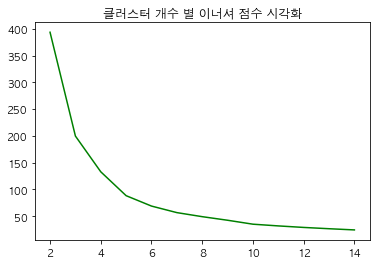

In [7]:
# https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html
# 실루엣 점수 시각화
## 엘보 지점이 가장 좋은데 뚜렷하게 보이지 않아 실루엣 계수 확인 진행 
plt.plot(cluster_num, inertia_list, color = '#008000')
plt.title('클러스터 개수 별 이너셔 점수 시각화')
plt.show()

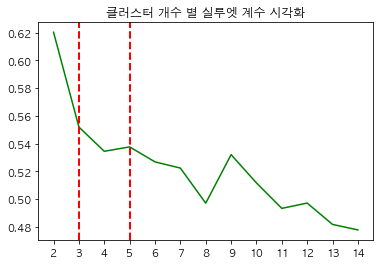

In [8]:
# 실루엣계수 그래프
# 1에 가까울수록 좋은 모델인데, 갈수록 낮아짐
# 3 혹은 5 가 좋은 클러스터 개수일것으로 보임
# 추가적으로 실루엣 그래프 확인
plt.plot(cluster_num, silhouette_list, color = '#008000')
plt.xticks(np.arange(2, 15))
plt.axvline(x=3, color='r', linestyle='--', linewidth=2)
plt.axvline(x=5, color='r', linestyle='--', linewidth=2)
plt.title('클러스터 개수 별 실루엣 계수 시각화')
plt.show()

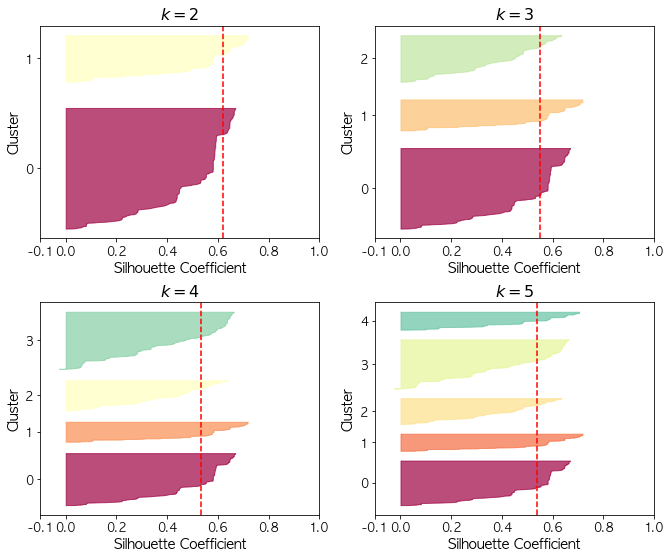

In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2,3,4,5):
#     plt.subplot(2, 2, k - 1)
    plt.subplot(2, 2, k - 1)
    plt.subplots_adjust(hspace=0.3)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df_order[['minmax_r', 'minmax_f', 'minmax_m']], df_order['cluster'])

    padding = len(df_order[['minmax_r', 'minmax_f', 'minmax_m']]) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[df_order['cluster'] == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 3, 4, 5):
        plt.ylabel("Cluster")
    
    if k in (2,3, 4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_list[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

# save_fig("silhouette_analysis_plot")
plt.show()
# 세로축 기준으로 각 클러스터별 너비가 비슷하고(클러스터 내 데이터 갯수가 비슷하다는 의미)
# 가로축 기준 붉은색 실선보다 큰 경우(실루엣 계수가 유의미할만큼 크다는 의미)
# 모두 고려하여 k=5 선택

In [10]:
df_order.columns

Index(['id', 'r', 'minmax_r', 'f', 'minmax_f', 'm', 'minmax_m', 'cluster'], dtype='object')

In [11]:
base = [ 'minmax_r',  'minmax_f', 'minmax_m']

In [12]:
df_order

,id,r,minmax_r,f,minmax_f,m,minmax_m,cluster
0,120,3.0,0.988950,124,0.05384615384615384615,3960725,0.48274836850040042573,6
1,121,37.0,0.801105,2,0.99230769230769230769,44400,0.99456210362557789901,0
2,123,45.0,0.756906,2,0.99230769230769230769,55500,0.99311147517674143371,0
3,135,154.0,0.154696,1,1.00000000000000000000,42000,0.99487575301992091853,5
4,138,97.0,0.469613,2,0.99230769230769230769,75600,0.99048466149911864520,1
...,...,...,...,...,...,...,...,...
35952,89342,1.0,1.000000,2,0.99230769230769230769,63000,0.99213132081941949770,10
35953,89343,1.0,1.000000,5,0.96923076923076923077,45500,0.99441834765317068173,10
35954,89348,1.0,1.000000,1,1.00000000000000000000,26000,0.99696674898220771536,10
35955,89359,1.0,1.000000,2,0.99230769230769230769,216000,0.97213617193005200307,10
